## IMPORT MODUL

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import kagglehub

2025-05-19 13:49:57.780770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747662597.971681      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747662598.027872      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## LOAD DATA

In [2]:
# Download dataset
path = kagglehub.dataset_download("charuchaudhry/plantvillage-tomato-leaf-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-tomato-leaf-dataset


In [3]:
# Path ke folder "plantvillage"
dataset_path = os.path.join(path, "plantvillage/plantvillage")
print(os.listdir(dataset_path))

['Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite']


In [4]:
# Menghitung jumlah gambar tiap label
labels = sorted(os.listdir(dataset_path))

label_counts = {label: len(os.listdir(os.path.join(dataset_path, label))) for label in labels}
label_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Jumlah Gambar'])

print("Jumlah gambar per label:")
print(label_df)

Jumlah gambar per label:
                                           Label  Jumlah Gambar
0                        Tomato___Bacterial_spot           1702
1                          Tomato___Early_blight            800
2                           Tomato___Late_blight           1527
3                             Tomato___Leaf_Mold            761
4                    Tomato___Septoria_leaf_spot           1417
5  Tomato___Spider_mites Two-spotted_spider_mite           1341
6                           Tomato___Target_Spot           1123
7         Tomato___Tomato_Yellow_Leaf_Curl_Virus           4286
8                   Tomato___Tomato_mosaic_virus            299
9                               Tomato___healthy           1273


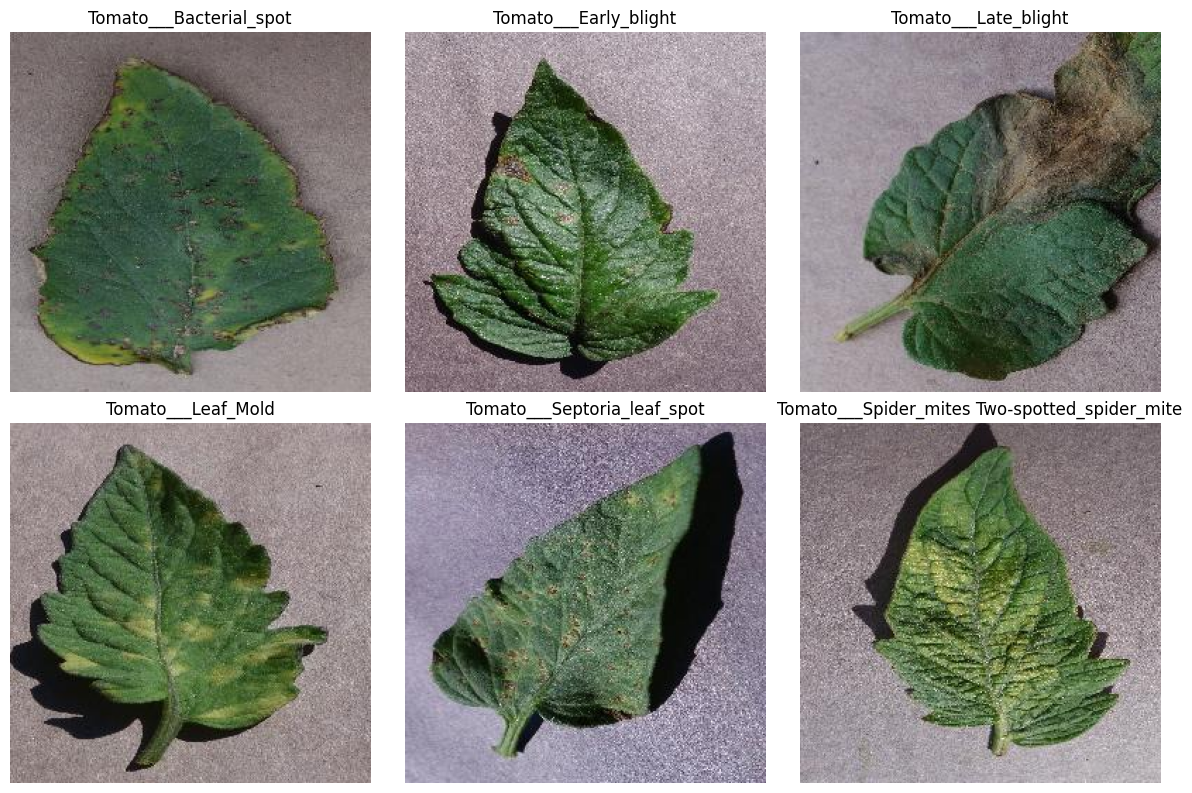

In [5]:
# Menampilkan beberapa sampel gambar
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels[:6]):
    image_folder = os.path.join(dataset_path, label)
    image_file = random.choice(os.listdir(image_folder))
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

## PREPROCESSING DAN AUGMENTASI DATA

In [6]:
image_size = (224, 224)
batch_size = 32

# Buat dataframe berisi path file dan label
filepaths = []
filelabels = []

for label in labels:
    folder = os.path.join(dataset_path, label)
    files = os.listdir(folder)
    for f in files:
        filepaths.append(os.path.join(folder, f))
        filelabels.append(label)

df = pd.DataFrame({
    'filepath': filepaths,
    'label': filelabels
})

print("Total data:", len(df))

Total data: 14529


In [7]:
# Cek duplikasi
duplicates = df.duplicated(subset=['filepath']).sum()
print(f"Jumlah data duplikat: {duplicates}")

Jumlah data duplikat: 0


In [8]:
# Split data train dan validasi (80:20)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(f"Jumlah train: {len(train_df)}")
print(f"Jumlah validasi: {len(val_df)}")

Jumlah train: 11623
Jumlah validasi: 2906


In [9]:
# Buat ImageDataGenerator tanpa augmentasi, hanya preprocess_input DenseNet121
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Buat generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 11623 validated image filenames belonging to 10 classes.
Found 2906 validated image filenames belonging to 10 classes.


## MODELING PRETRAINED DENSENET121

In [10]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base model (optional: untuk awal training)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(len(labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1747662724.933100      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,047,754 (26.89 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

## TRAINING

In [11]:
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1747662777.081297      81 service.cc:148] XLA service 0x7f7de0089bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747662777.082135      81 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747662779.702687      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/364 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0312 - loss: 3.3176       

I0000 00:00:1747662790.017657      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


364/364 ━━━━━━━━━━━━━━━━━━━━ 137s 291ms/step - accuracy: 0.2329 - loss: 2.3419 - val_accuracy: 0.5496 - val_loss: 1.4408
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.4808 - loss: 1.5580 - val_accuracy: 0.7085 - val_loss: 1.0881
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.6044 - loss: 1.2220 - val_accuracy: 0.7629 - val_loss: 0.9000
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 39s 106ms/step - accuracy: 0.6730 - loss: 1.0219 - val_accuracy: 0.7897 - val_loss: 0.7806
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - accuracy: 0.7026 - loss: 0.9097 - val_accuracy: 0.8204 - val_loss: 0.6961
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.7416 - loss: 0.8138 - val_accuracy: 0.8334 - val_loss: 0.6355
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - accuracy: 0.7661 - loss: 0.7386 - val_accuracy: 0.8417 - val_loss: 0.5881
Epoch 8/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.7821 - loss: 0.6892 - val

## PLOT ACCURACY DAN LOSS

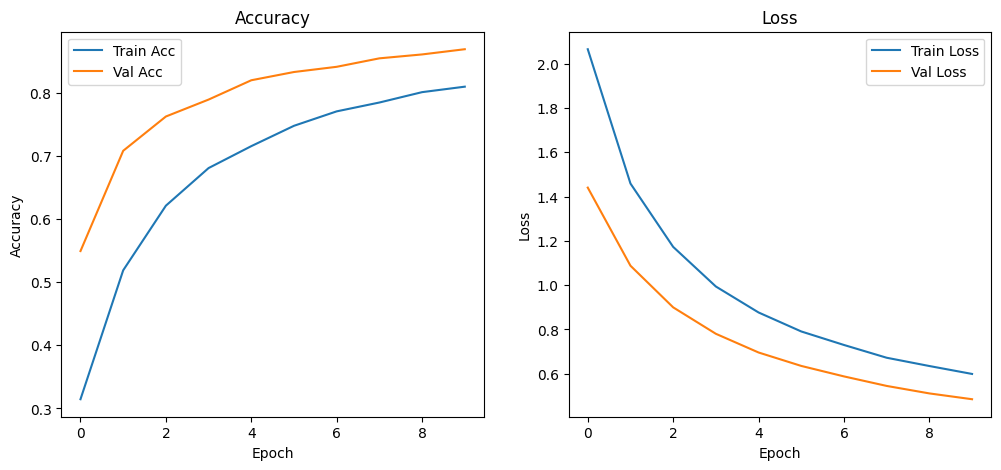

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## FINE-TUNE BASE MODEL

In [13]:
base_model.trainable = True
fine_tune_at = 300
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Epoch 1/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 141s 212ms/step - accuracy: 0.5820 - loss: 1.4655 - val_accuracy: 0.8950 - val_loss: 0.3370
Epoch 2/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.8782 - loss: 0.3816 - val_accuracy: 0.9319 - val_loss: 0.2221
Epoch 3/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.9248 - loss: 0.2533 - val_accuracy: 0.9491 - val_loss: 0.1691
Epoch 4/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.9316 - loss: 0.2076 - val_accuracy: 0.9549 - val_loss: 0.1406
Epoch 5/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - accuracy: 0.9511 - loss: 0.1575 - val_accuracy: 0.9618 - val_loss: 0.1172


In [14]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation Loss: {loss:.4f}")

91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9626 - loss: 0.1177
Validation Accuracy: 0.9618
Validation Loss: 0.1172


## PREDIKSI

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

test_dir = '/kaggle/input/data-test'

for img_name in os.listdir(test_dir):
    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        file_path = os.path.join(test_dir, img_name)
        
        img = load_img(file_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        pred = model.predict(img_array)
        class_idx = np.argmax(pred)
        confidence = np.max(pred)

        label_mapping = {v: k for k, v in train_generator.class_indices.items()}
        predicted_label = label_mapping[class_idx]

        print(f"{img_name} → {predicted_label} ({confidence:.2%})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
late-blight.jpeg → Tomato___Late_blight (99.44%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
early-blight.jpg → Tomato___Early_blight (96.93%)
